In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

%matplotlib notebook

import sys, time
import numpy as np
import math as m
import matplotlib.pyplot as plt
import extra_data as ex
import xarray as xr
import dask.array as da
from extra_data.components import AGIPD1M
from matplotlib.colors import LogNorm
import matplotlib as mpl
from extra_geom import AGIPD_1MGeometry
import scipy.fft as fft
from scipy import signal
from scipy.optimize import curve_fit
from scipy import ndimage
from tqdm import tqdm

plt.rcParams.update({'font.size': 12})

from extra_geom import LPD_1MGeometry
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

In [2]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)

def Ngauss_pdf(x, N, mu, sigma) :
    """Non-normalized (extended) Gaussian"""
    return N * gauss_pdf(x, mu, sigma)


def Ngauss_pdf_bkg(x, N, mu, sigma, bkg) :
    """Non-normalized (extended) Gaussian"""
    return N * gauss_pdf(x, mu, sigma)+bkg

In [3]:
run = ex.open_run(proposal=3118, run=1)
#run.info()  # Show overview info about this data

from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
partition = 'exfel'  # For EuXFEL staff
#partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 16 GB RAM. silence_logs="debug",
    processes=5, cores=70, memory='600GB',nanny=True,death_timeout=100,walltime="24:00:00", job_name='run',
    local_directory = '/gpfs/exfel/exp/MID/201901/p002542/usr/Jo',log_directory = '/gpfs/exfel/exp/MID/201901/p002542/usr/Jo',
)

# Submit 2 SLURM jobs, for 32 Dask workers
cluster.scale(60)

client = Client(cluster)

# Get a notbook widget showing the cluster state
#cluster

# Loading AGIPD Data

In [4]:
# data addresses

cycle = 202202
proposal = 3118

# add desired runs into run_no array. [23 - 40]
run_no = [39, 36, 33, 23, 26, 29] # [8.7 - 9.2 keV]
E_rad = [8.7, 8.8, 8.9, 9.0, 9.1, 9.2]

#run_no = np.array([40, 34, 26]) # [8.7, 8.9, 9.1 keV]
run_p = []
run_r = []

for i in tqdm(range(len(run_no))):
    rundir_p = '/gpfs/exfel/exp/MID/{:06d}/p{:06d}/proc/r{:04d}'.format(cycle,proposal,run_no[i])
    rundir_r = '/gpfs/exfel/exp/MID/{:06d}/p{:06d}/raw/r{:04d}'.format(cycle,proposal,run_no[i])
    run_p_temp = ex.RunDirectory(rundir_p)
    run_r_temp = ex.RunDirectory(rundir_r)
    run_p.append(run_p_temp)
    run_r.append(run_r_temp)

agp = []
for run in run_p:
    agp_temp = AGIPD1M(run, min_modules=16)
    agp.append(agp_temp)

arr = []
for i in tqdm(range(len(agp))):
    arr_temp = agp[i].get_dask_array("image.data")
    arr.append(arr_temp.unstack())

all_yh_average = []
all_yv_average = []
#arr

100%|██████████| 6/6 [00:39<00:00,  6.58s/it]


In [5]:
#load positions of AGIPD quadrants
def load_AGIPD_Motors(run):
    motVal=[]
    for name in ( ['q1m1','q2m1','q3m1','q4m1','q1m2','q2m2','q3m2','q4m2']):
        prop = f'{name}ActualPosition'
        arr = run['MID_AGIPD_MOTION/MDL/DOWNSAMPLER',prop].xarray().data[0]
        motVal.append(arr)
    return motVal

#q1m1=[]; q2m1=[]; q3m1=[]; q4m1=[]; q1m2=[]; q2m2=[]; q3m2=2=[]; q4m2=[]
quad_pos = []
geom = []
g = []

for run in run_r:
    q1m1_t, q2m1_t, q3m1_t, q4m1_t, q1m2_t, q2m2_t, q3m2_t, q4m2_t = load_AGIPD_Motors(run)
    #q1m1.append(q1m1_t); q2m1.append(q2m1_t); q3m1.append(q3m1_t); q4m1.append(q4m1_t)
    #q1m2.append(q1m2_t); q2m2.append(q2m2_t); q3m2.append(q3m2_t); q4m2.append(q4m2_t)
    
    # correcting the detector geometry
    q1_x_t = -542 + 0*q1m1_t
    q1_y_t = 660 + q1m1_t/(-0.2)
    q2_x_t = -608 + 0*q2m1_t
    q2_y_t = -35 + q2m1_t/0.2
    q3_x_t = 534 + 0*q3m1_t
    q3_y_t = -221 + q3m1_t/0.2
    q4_x_t = 588 + 0*q4m1_t
    q4_y_t = 474 + q4m1_t/(-0.2) 
    
    # making the quadrant position matrix
    quad_pos_t = [(q1_x_t, q1_y_t),
               (q2_x_t, q2_y_t),
               (q3_x_t, q3_y_t),
               (q4_x_t, q4_y_t)]
    
    # append the guadrant positions to list
    quad_pos.append(quad_pos_t)
    
    # append geometry of the run to list
    geom_t = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos_t)
    geom.append(geom_t)
    
# append the pixel position of the run to list
for geo in geom:
    g_t = geo.get_pixel_positions()
    g.append(g_t)


# geom.inspect();

<IPython.core.display.Javascript object>


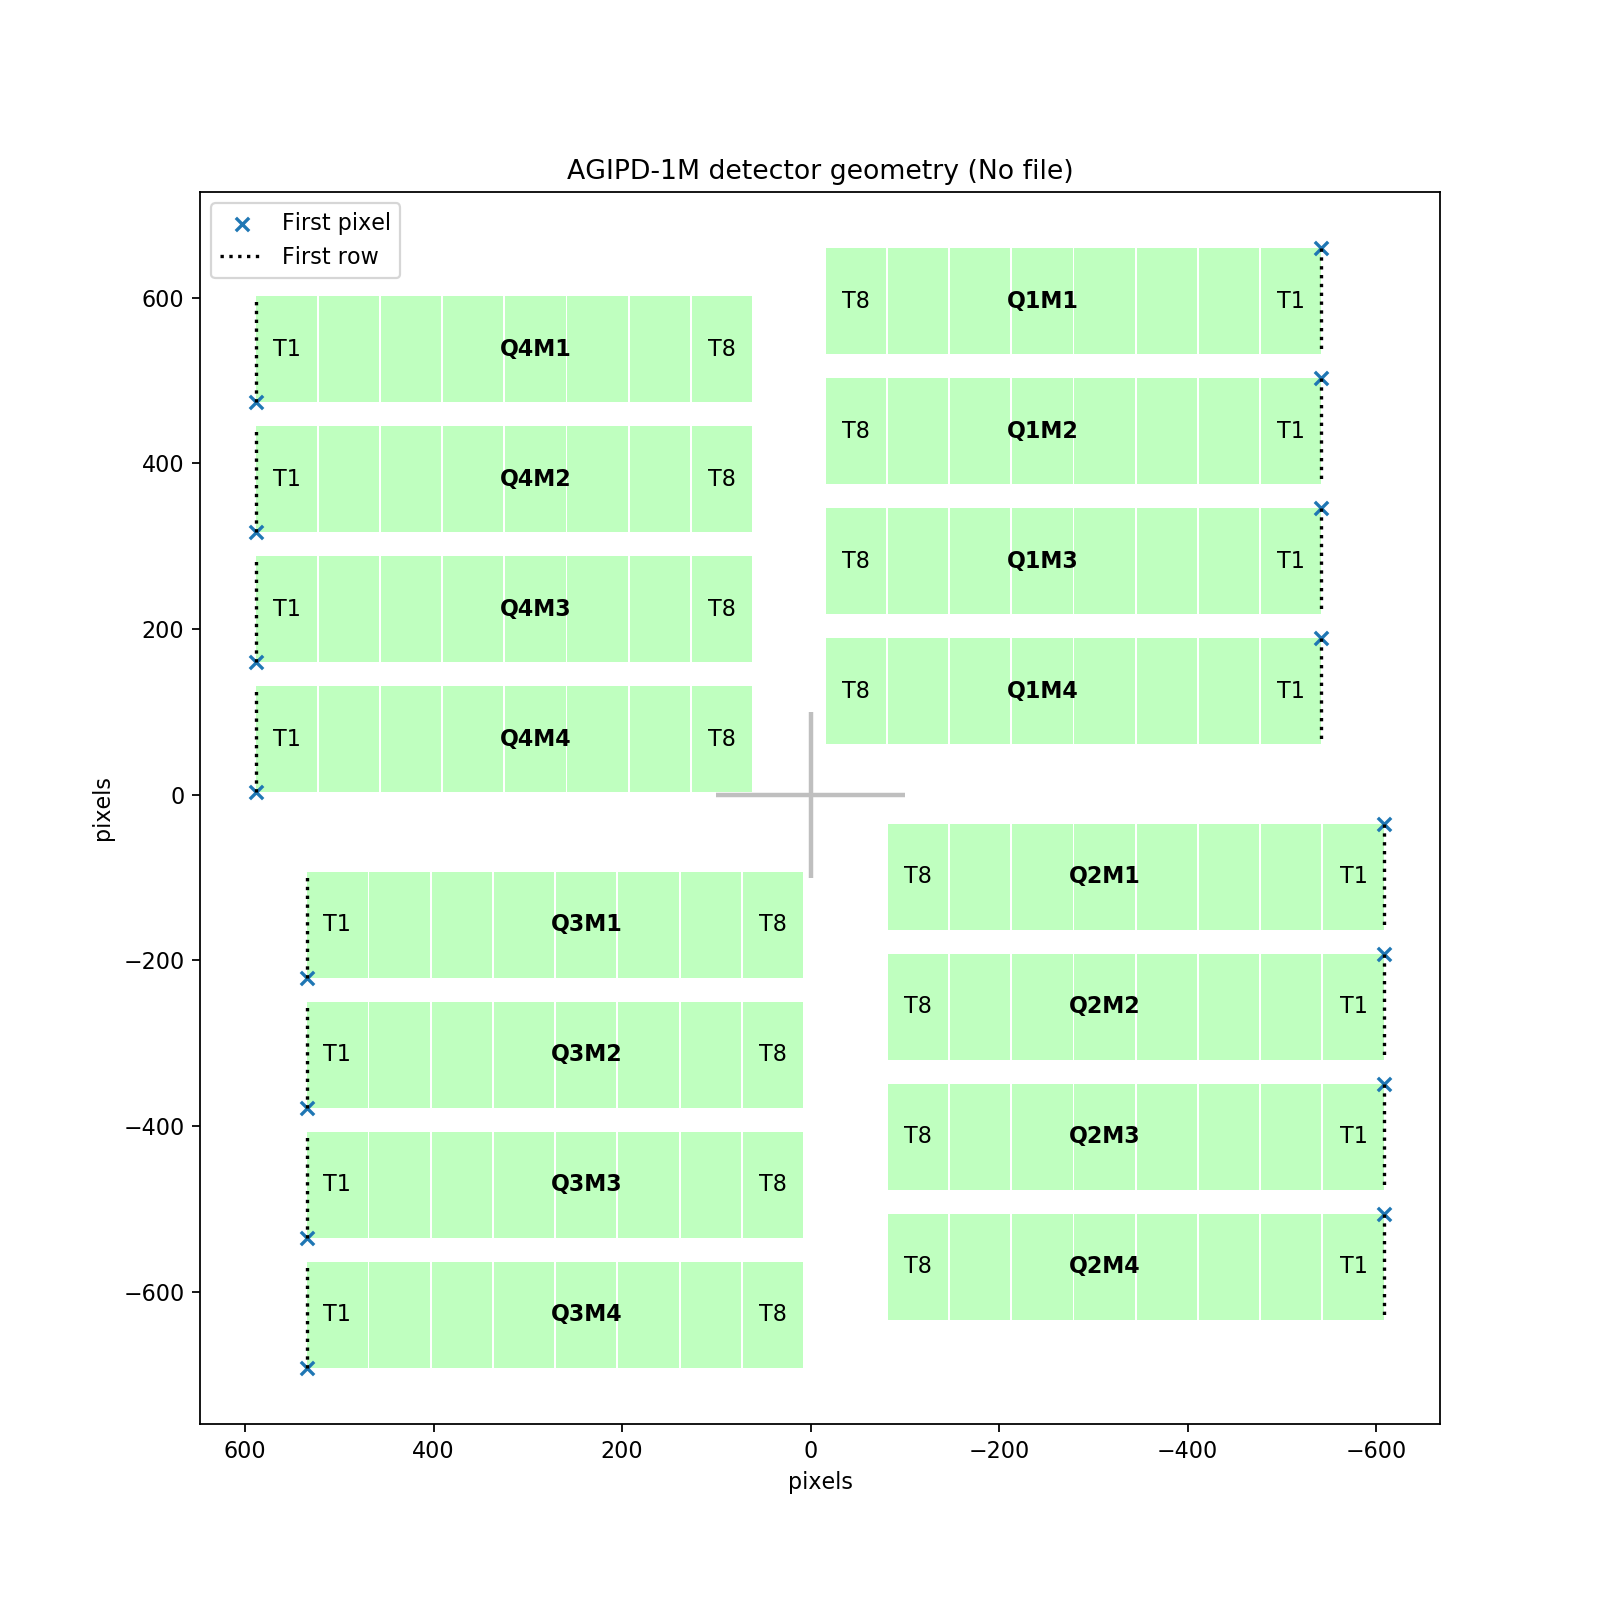

In [7]:
geom[0].inspect()

# Analyse consistency

In [6]:
# Define run and pulseIds to look at
arr_no = 2

pulse_start = 70    # The first pulse
pulse_end = 88     # The last pulse

pulseId_no = list(range(pulse_start, pulse_end + 1))


single_img = []
module_img = []
zoom_img = []

#--------------select module to zoom and correlate--------#    
show_trainId = 1562
show_module = 3

a = int(128/2)
b = 512 - (128-a)


for i in tqdm(range(len(pulseId_no))):
    single_img_temp = arr[arr_no].isel(pulseId = pulseId_no[i], trainId = show_trainId) # selected first array. 
    single_img.append(ndimage.rotate(single_img_temp, 270))
    module_img_temp = arr[arr_no].isel(module = show_module, pulseId = pulseId_no[i], trainId = show_trainId)
    module_img.append(ndimage.rotate(module_img_temp, 270))
    
for img in tqdm(module_img):
    zoom_img_temp = img[a:,:a]
    zoom_img.append(zoom_img_temp)
    



100%|██████████| 19/19 [00:00<00:00, 133487.06it/s]


In [21]:
len(module_img)

19

In [7]:
x = 511
y = 127
#g[3][xxx][yyy] # positions in real space bottom left corner

#print(g[3][x][y], g[3][i][j])

dx = []
dy = []

for geo in g:
    dx_temp = []
    dy_temp = []
    for k in range(a):
        
        rx1 = 0 - geo[3][(x - k)][y][0] # distance from origin
        ry1 = geo[3][x][y][1] - 0 
        dx_temp.append(np.sqrt(rx1**2 + ry1**2))
        
        rx2 = 0 - geo[3][x][y][0] 
        ry2 = geo[3][x][(y - k)][1] - 0
        dy_temp.append(np.sqrt(rx2**2 + ry2**2))
        
    dx.append(dx_temp)
    dy.append(dy_temp)

#---------

L = 7.9               # detector/sample length in meters
wavelength_A = (12.3984 / np.array(E_rad))   # array in armstrong

x_theta = []
y_theta = []

for x in dx:
    x_theta.append(np.arctan(np.array(x) / L) / 2)
    
for y in dy:
    y_theta.append(np.arctan(np.array(y) / L) / 2)

q_x = []
q_y = []

for x in range(len(arr)):
    q_x.append( ((4 * np.pi) / wavelength_A[x]) * np.sin(x_theta[x]) )    #A^{-1}
    
for y in range(len(arr)):
    q_y.append( ((4 * np.pi) / wavelength_A[y]) * np.sin(y_theta[y]) )    #A^{-1}

<IPython.core.display.Javascript object>


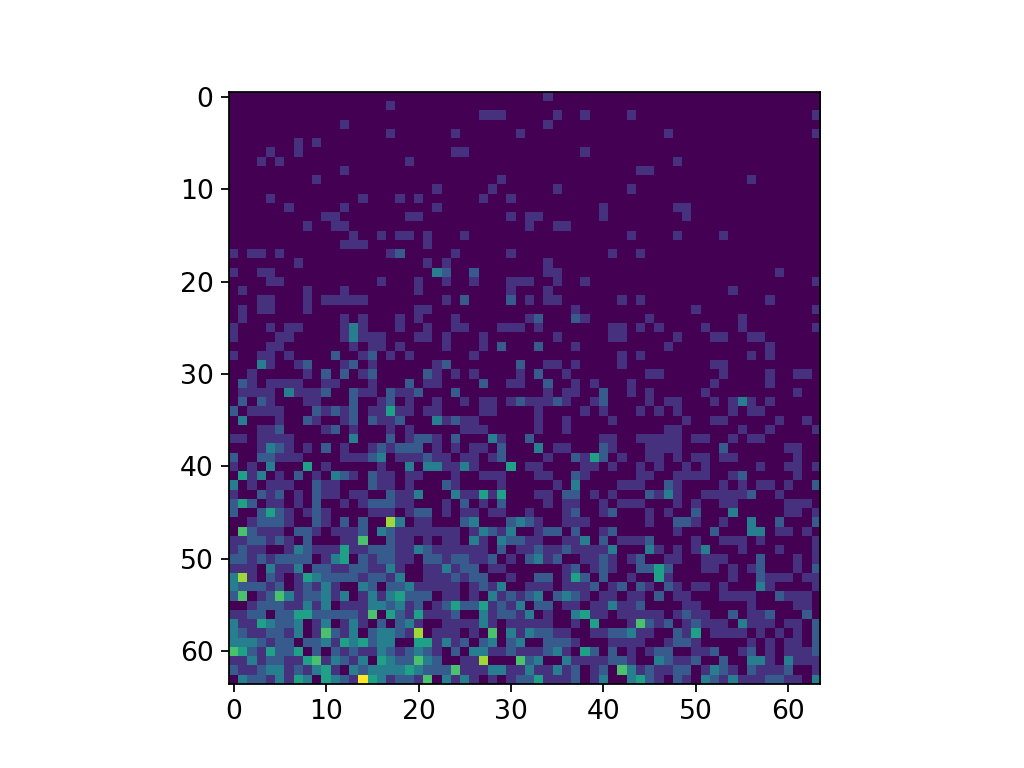

In [27]:
plt.figure()
plt.imshow(zoom_img[9])

In [9]:
a = int(128/2)
b = 512 - (128-a)
a, b

(64, 448)

# Correlate

In [8]:
# create zoomed in array of single shot for EACH run. list.shape = runs, pulses

a = int(128)
b = 512 - (128-a)

zoom_img = []

show_module = 3
show_trainId = 1562

pulse_start = 70    # The first pulse
pulse_end = 88     # The last pulse

pulseId_no = list(range(pulse_start, pulse_end + 1))

# ------------------------------------------------------------------------------------------------------------

# average image over multiple pulses, washing out the speckles a little. 
average_imgs = []

# individual images of pulses for each run.
single_imgs = [] # dimension of number of runs. 

for array in tqdm(arr):
    # list of images of individual pulses
    single_group = [] 
    
    # Add zoomed module image to array to be averaged
    for pulse in pulseId_no:
        
        pulse_module_img_temp = array.isel(module = show_module, pulseId = pulse, trainId = show_trainId)
        single_group.append(ndimage.rotate(pulse_module_img_temp, 270)[:,:a])
        
    # append all single pulse images into one element of 'single_imgs'
    single_imgs.append(single_group)
    
    
# average for 1 run
for img in tqdm(single_imgs):
    average_t = np.mean(img, axis=0)
    average_imgs.append(average_t)
   

100%|██████████| 6/6 [00:00<00:00, 1620.99it/s]


<IPython.core.display.Javascript object>


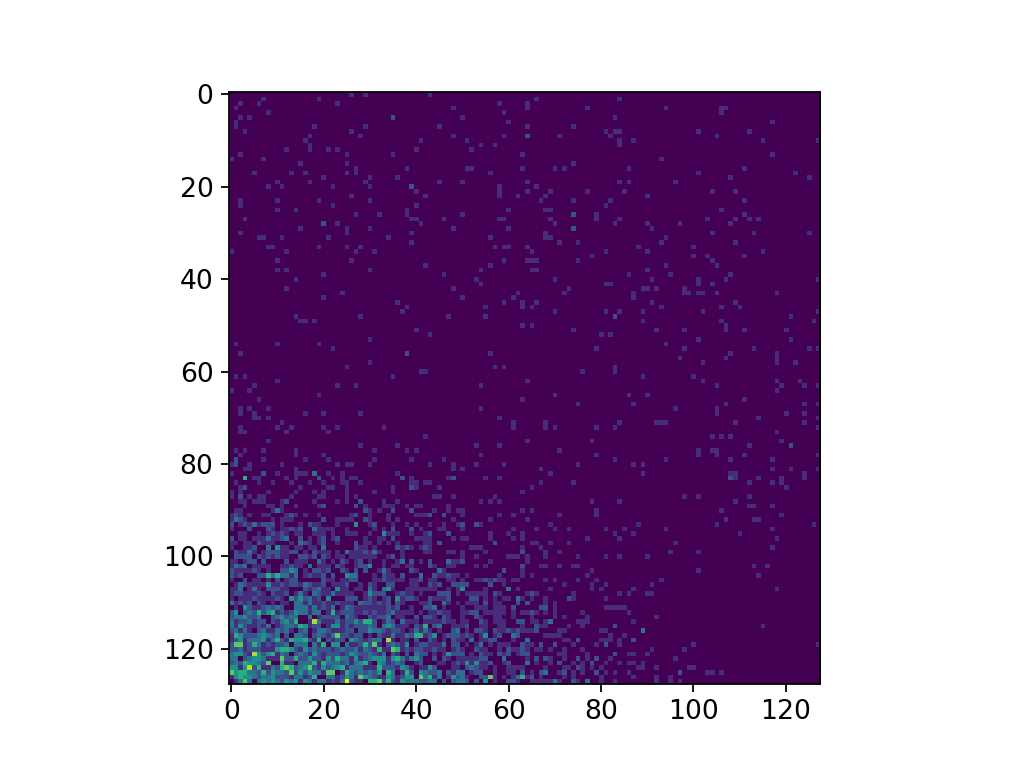

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2b8c27f0bbe0>)

In [30]:
plt.figure(), plt.imshow(single_imgs[4][0])

<IPython.core.display.Javascript object>


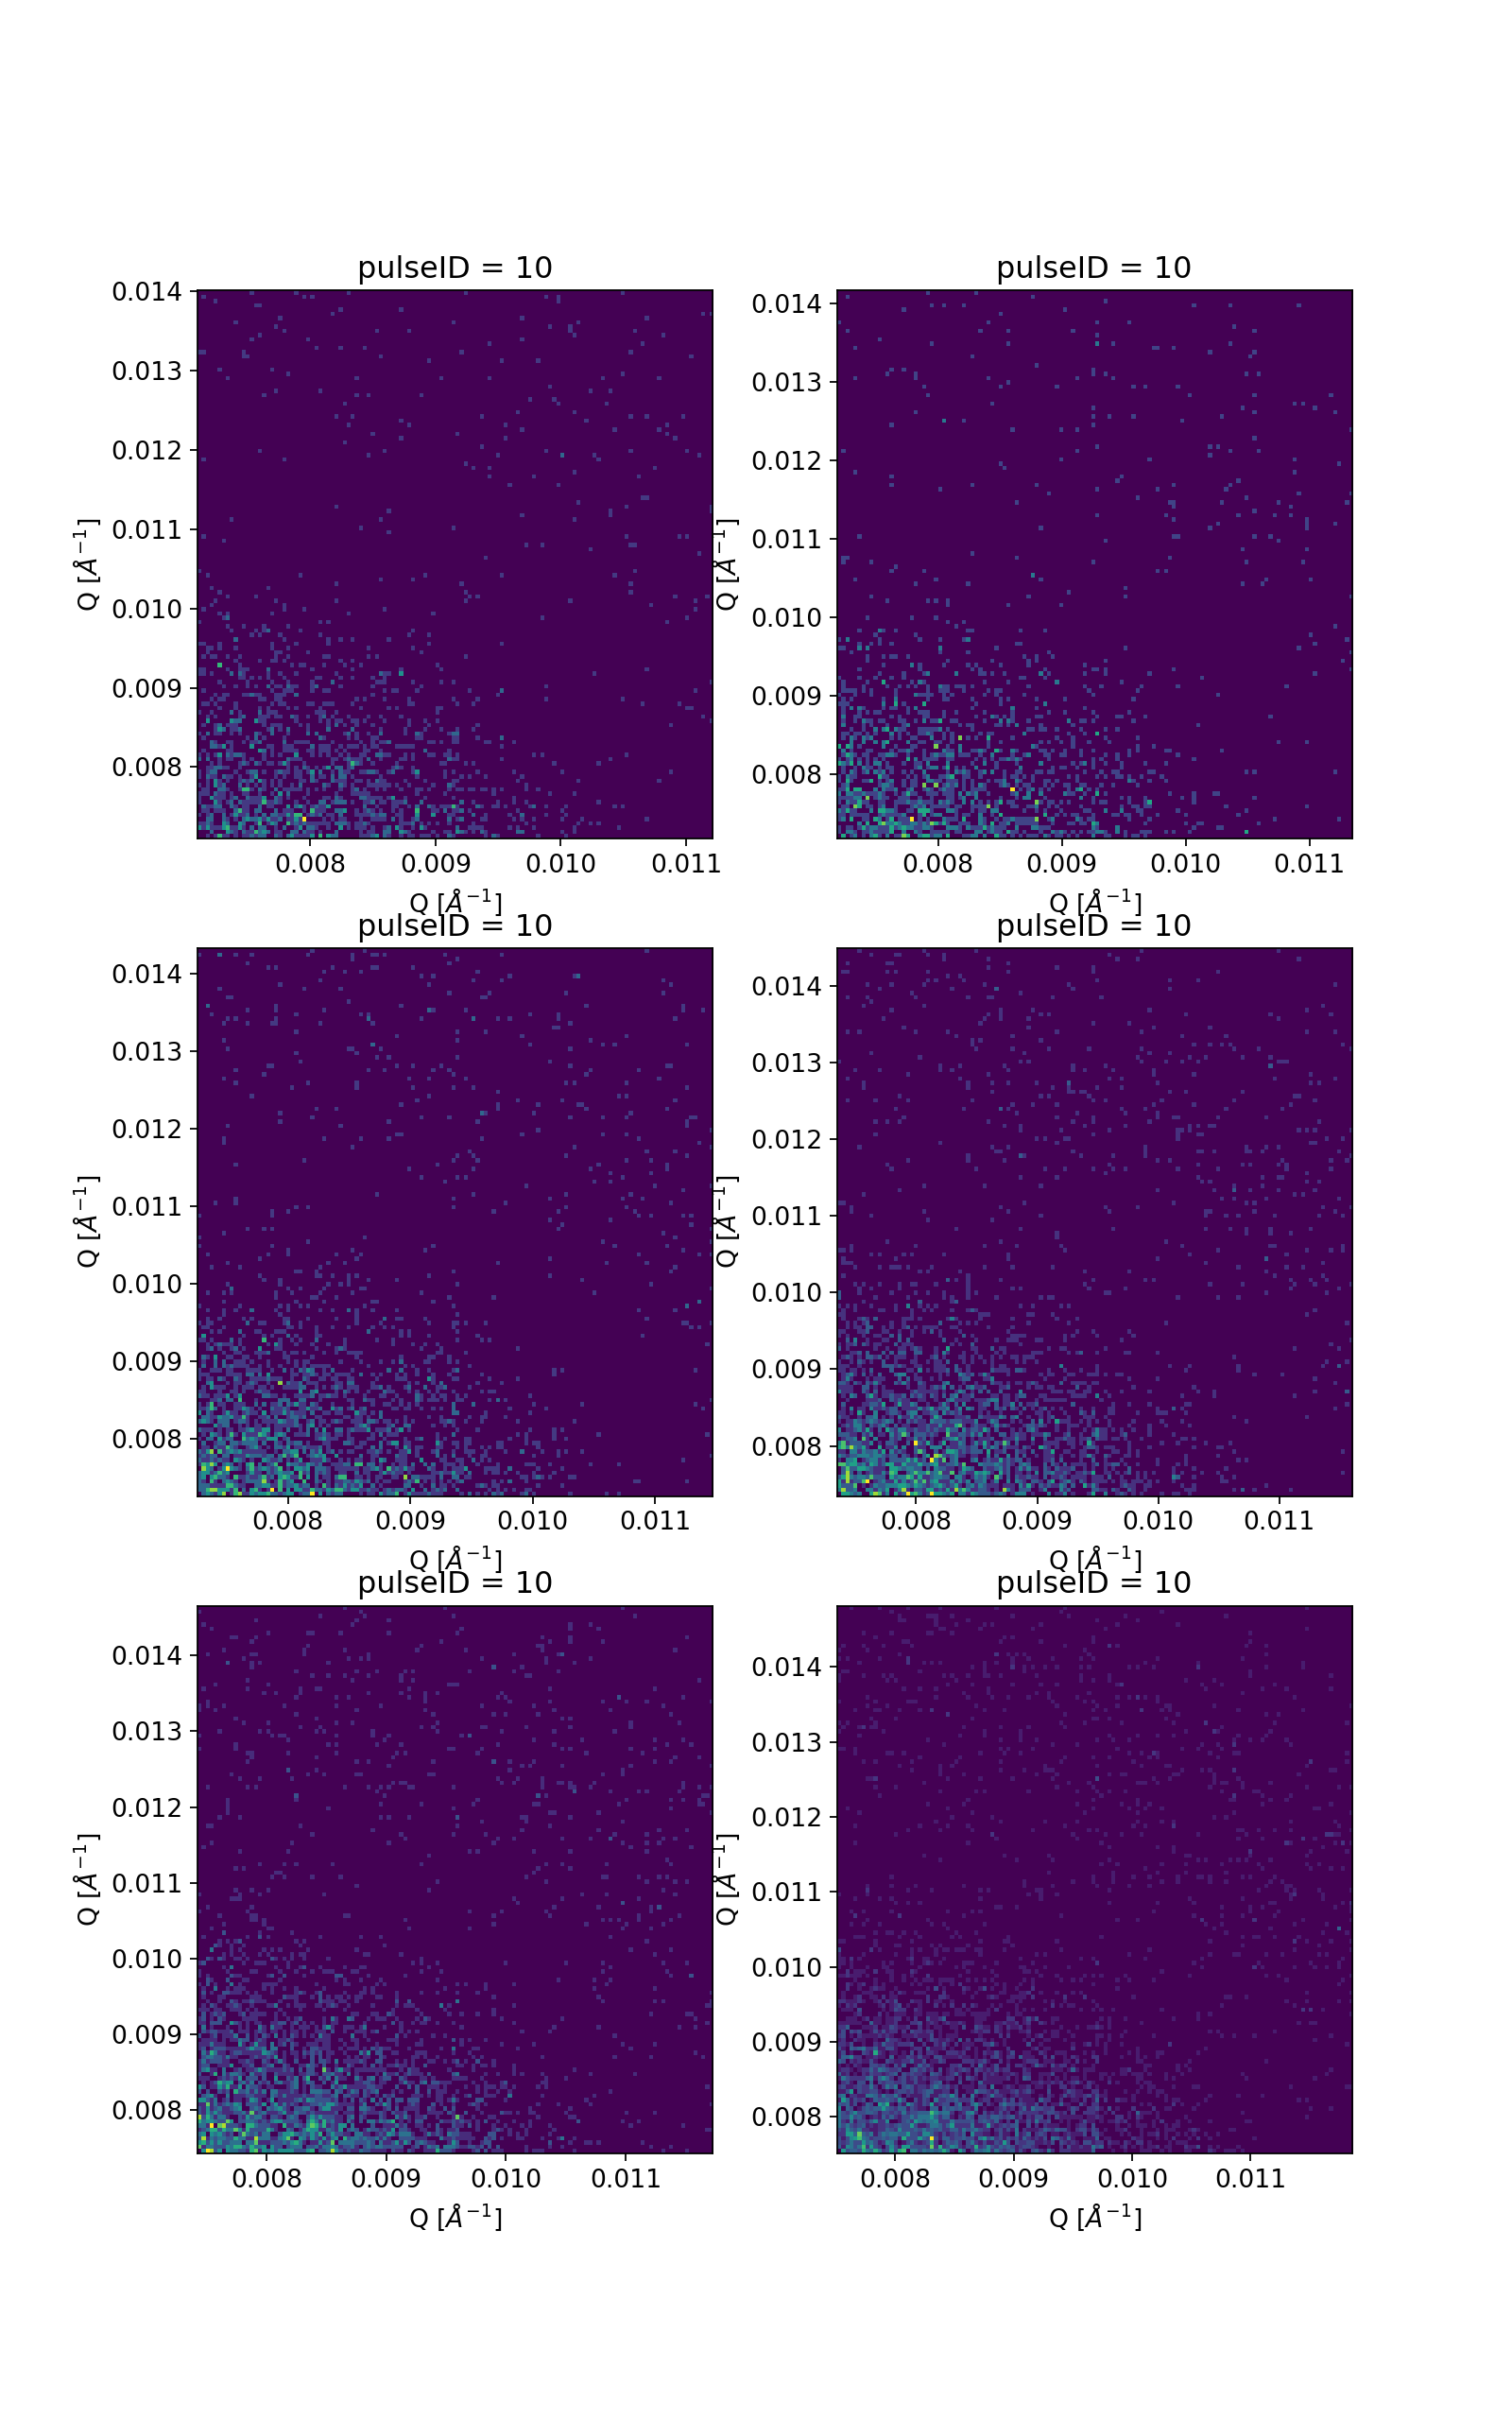

Text(0.5, 1.0, 'pulseID = 10')

In [9]:
q_extent = []
asp = []

for i in range(len(arr)):
    l = np.array([q_x[i][0], q_x[i][-1], q_y[i][0], q_y[i][-1]])
    q_extent.append(l)
    asp.append(q_x[i][0]/ q_x[i][-1] )

fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6)) = plt.subplots(figsize=(10, 16), ncols=2, nrows=3)

pid = 10

ax1.imshow(single_imgs[0][pid], extent = q_extent[0], aspect=asp[0])
ax1.set_xlabel(r'Q [$\AA^{-1}$]')
ax1.set_ylabel(r'Q [$\AA^{-1}$]')
ax1.set_title('pulseID = {}'.format(pid))

ax2.imshow(single_imgs[1][pid], extent = q_extent[1], aspect=asp[1])
ax2.set_xlabel(r'Q [$\AA^{-1}$]')
ax2.set_ylabel(r'Q [$\AA^{-1}$]')
ax2.set_title('pulseID = {}'.format(pid))

ax3.imshow(single_imgs[2][pid], extent = q_extent[2], aspect=asp[2])
ax3.set_xlabel(r'Q [$\AA^{-1}$]')
ax3.set_ylabel(r'Q [$\AA^{-1}$]')
ax3.set_title('pulseID = {}'.format(pid))

ax4.imshow(single_imgs[3][pid], extent = q_extent[3], aspect=asp[3])
ax4.set_xlabel(r'Q [$\AA^{-1}$]')
ax4.set_ylabel(r'Q [$\AA^{-1}$]')
ax4.set_title('pulseID = {}'.format(pid))

ax5.imshow(single_imgs[4][pid], extent = q_extent[4], aspect=asp[4])
ax5.set_xlabel(r'Q [$\AA^{-1}$]')
ax5.set_ylabel(r'Q [$\AA^{-1}$]')
ax5.set_title('pulseID = {}'.format(pid))

ax6.imshow(single_imgs[5][pid], extent = q_extent[5], aspect=asp[5])
ax6.set_xlabel(r'Q [$\AA^{-1}$]')
ax6.set_ylabel(r'Q [$\AA^{-1}$]')
ax6.set_title('pulseID = {}'.format(pid))




<IPython.core.display.Javascript object>


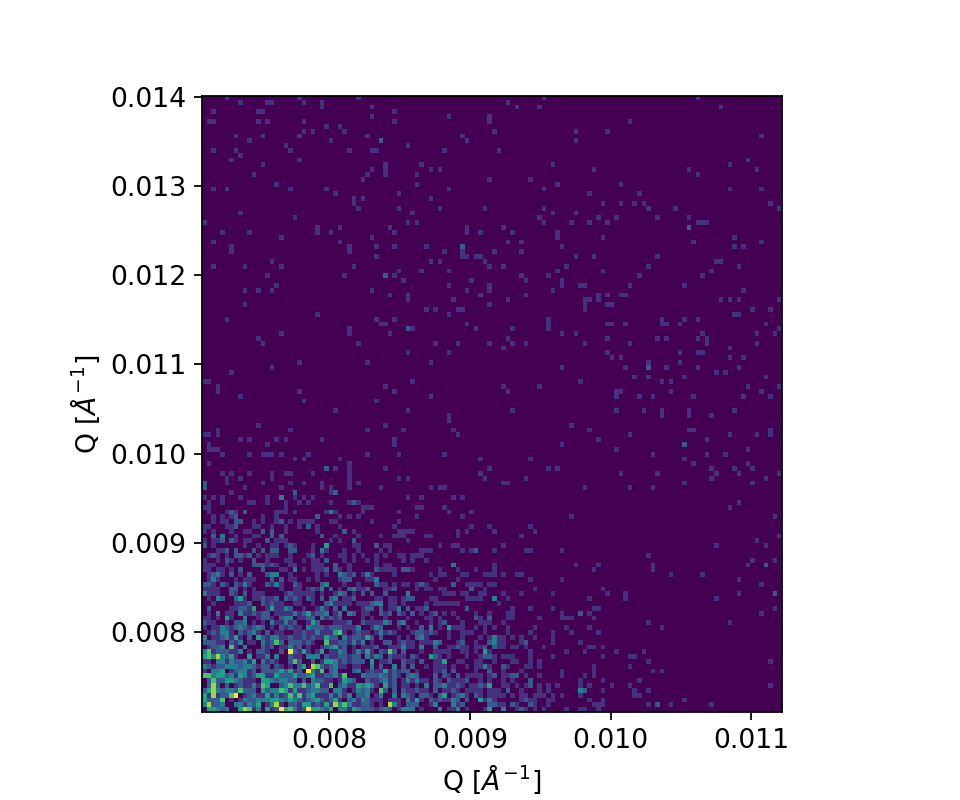

(None, (128, 128))

In [13]:
fig, (ax1) = plt.subplots(figsize=(6, 5), ncols=1)

ax1.imshow(single_imgs[3][10], extent = q_extent[0], aspect=asp[0])

ax1.set_xlabel(r'Q [$\AA^{-1}$]')
ax1.set_ylabel(r'Q [$\AA^{-1}$]')

plt.savefig('exp-speckle-zoom.png'), single_imgs[3][10].shape

In [10]:
# performing the autocorrelation

corr_pulses = []  # has shape (len(arr), len(pulses))

for i in range(len(single_imgs)):
    image = single_imgs[i]
    corr_of_run = []
    
    for j in range(len(single_imgs[i])):
        corr_img = signal.correlate2d(single_imgs[i][j], single_imgs[i][j], mode='full', boundary='fill', fillvalue=0)
        corr_of_run.append(corr_img)
    
    corr_pulses.append(corr_of_run)

# averaging the correlation functions for each run <C(I)>
corr = []

for img in corr_pulses:
    average = np.mean(img, axis=0)
    corr.append(average)

# correlating the averaged C(<I>)
corr_avg = []

for img in average_imgs:
    corr_img = signal.correlate2d(img, img, mode='full', boundary='fill', fillvalue=0)
    corr_avg.append(corr_img)


In [11]:
#Getting the 1D correlation functions:

od_corr = []
od_corr_avg = []

t_v = [] # center column of correlation matrix
t_h = [] # center row of correlation matrix
y_v = [] # normalised intensity of vertical
y_h = [] # normalised intensity of horizontal

for corri in corr:
    t_v_t = int(np.argmax(corri[int(len(corri[:,0])/2),:]))
    t_h_t = int(np.argmax(corri[int(len(corri[:,0])/2),:]))
    x_v = np.linspace(-len(corri[:,t_v_t])/2,len(corri[:,t_v_t])/2,len(corri[:,t_v_t]))
    x_h = np.linspace(-len(corri[t_h_t,:])/2,len(corri[t_h_t,:])/2,len(corri[t_h_t,:]))
    y_v_t = corri[:,t_v_t]/int(np.floor(max(corri[:,t_v_t])))
    y_h_t = corri[t_h_t,:]/int(np.floor(max(corri[t_h_t,:])))
    t_v.append(t_v_t)
    t_h.append(t_h_t)
    y_v.append(y_v_t)
    y_h.append(y_h_t)
    od_corr.append(corri[t_h_t,:])

avg_t_v = [] # center column of correlation matrix
avg_t_h = [] # center row of correlation matrix
avg_y_v = [] # normalised intensity of vertical
avg_y_h = [] # normalised intensity of horizontal

for corri in corr_avg:
    t_v_t = int(np.argmax(corri[int(len(corri[:,0])/2),:]))
    t_h_t = int(np.argmax(corri[int(len(corri[:,0])/2),:]))
    x_v = np.linspace(-len(corri[:,t_v_t])/2,len(corri[:,t_v_t])/2,len(corri[:,t_v_t]))
    x_h = np.linspace(-len(corri[t_h_t,:])/2,len(corri[t_h_t,:])/2,len(corri[t_h_t,:]))
    y_v_t = corri[:,t_v_t]/int(np.floor(max(corri[:,t_v_t])))
    y_h_t = corri[t_h_t,:]/int(np.floor(max(corri[t_h_t,:])))
    avg_t_v.append(t_v_t)
    avg_t_h.append(t_h_t)
    avg_y_v.append(y_v_t)
    avg_y_h.append(y_h_t)
    od_corr_avg.append(corri[t_h_t,:])

## Subtract averaged image correlation

In [12]:
subtracted_ycut = []
for i in range(len(od_corr)):
    x = od_corr[i] - od_corr_avg[i]
    subtracted_ycut.append(x)
    
#normalising it for comparison

subtracted_ycut_normalised = []
for i in range(len(subtracted_ycut)):
    x = subtracted_ycut[i]/int(max(subtracted_ycut[i]))
    subtracted_ycut_normalised.append(x)


<IPython.core.display.Javascript object>


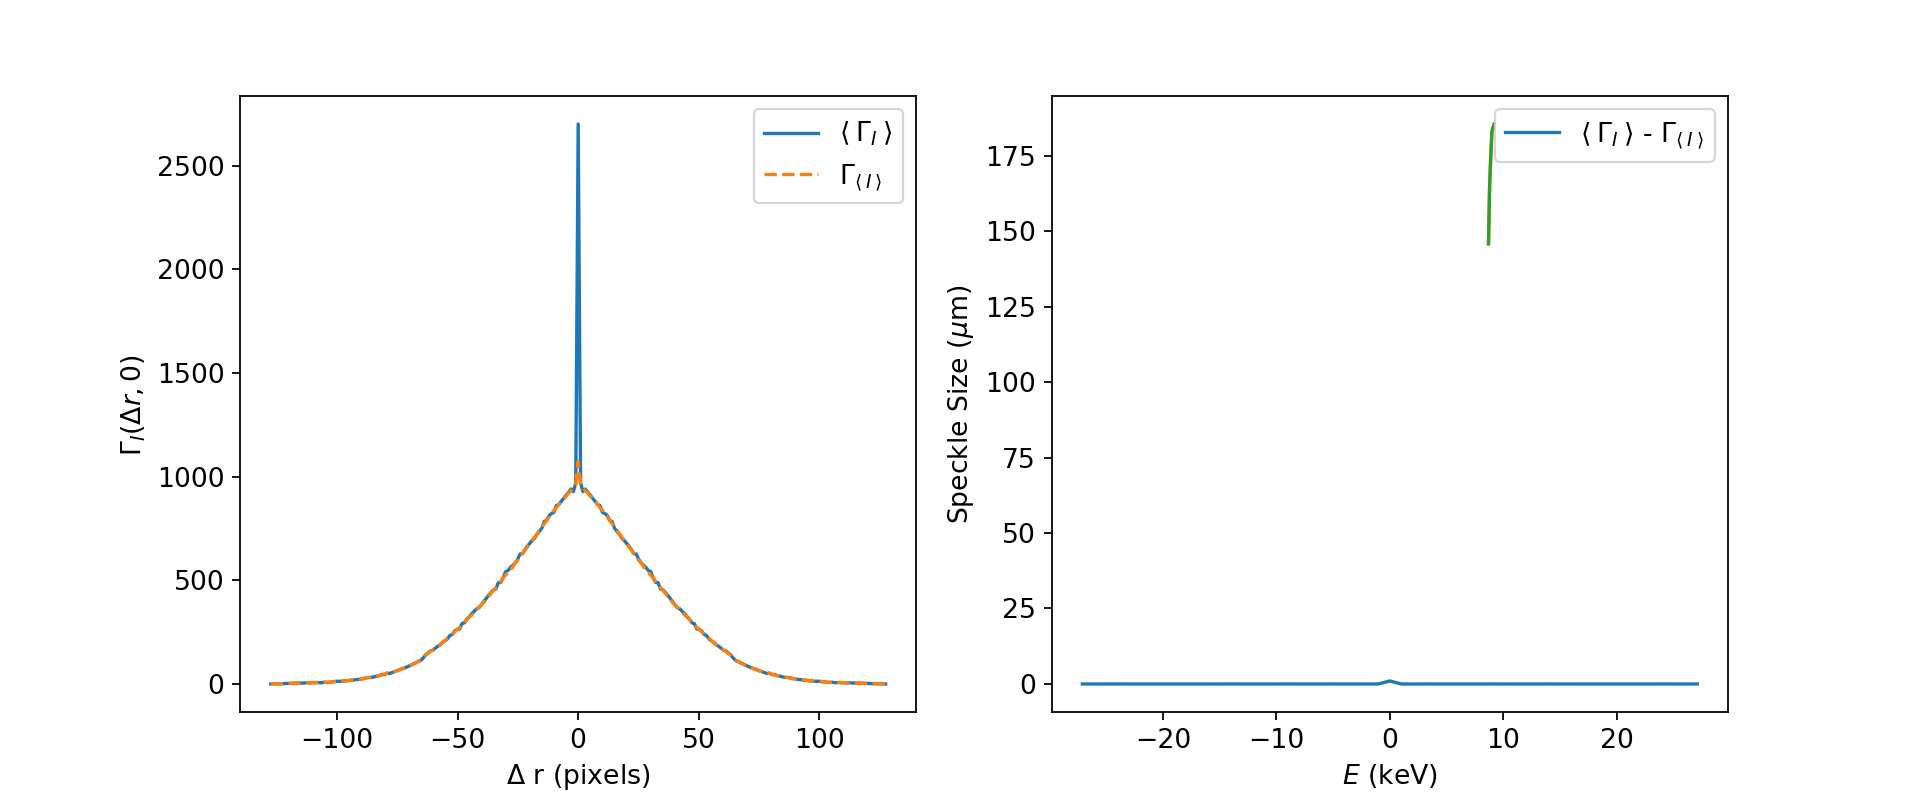

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)


ax1.plot(x_h,od_corr[0], label=r'$\langle \:\Gamma_{I}\: \rangle$')
ax1.plot(x_h,od_corr_avg[0], '--', label = r'$\Gamma_{\langle\: I\: \rangle}$')
    

ax2.plot(x_h[100:-100], subtracted_ycut_normalised[0][100:-100], label = r'$\langle \:\Gamma_{I}\: \rangle$ - $\Gamma_{\langle \: I \: \rangle}$') 
    
ax1.set_xlabel(r'$\Delta$ r (pixels)')
ax1.set_ylabel(r'$\Gamma_I(\Delta r, 0)$ ')
ax2.set_xlabel(r'$\Delta$ r (pixels)')
ax2.set_ylabel(r'$\Gamma_I(\Delta r, 0)$ / max[$\Gamma_I(\Delta r,0)$] ')

ax1.legend()
ax2.legend()

plt.savefig('exp_subtract_corr.png')

<IPython.core.display.Javascript object>


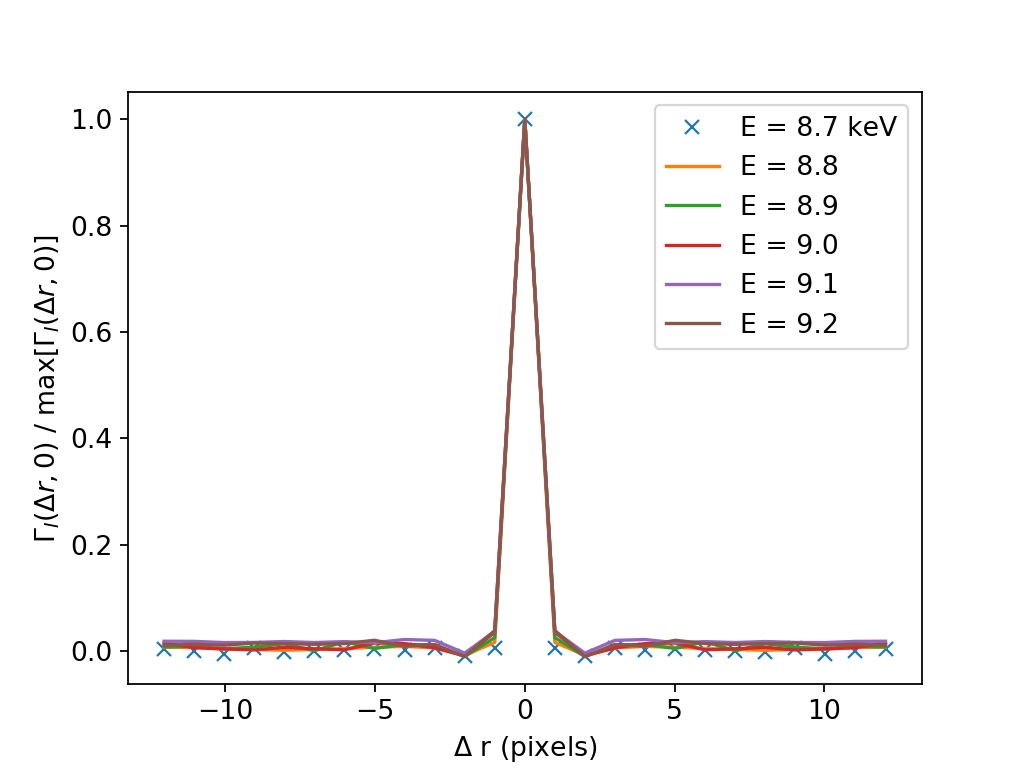

In [50]:
plt.figure()
plt.plot(x_v[115:-115], subtracted_ycut_normalised[0][115:-115], 'x', label = r'E = {} keV'.format(E_rad[0]) )
plt.plot(x_v[115:-115], subtracted_ycut_normalised[1][115:-115], label = r'E = {}'.format(E_rad[1])) 
plt.plot(x_v[115:-115], subtracted_ycut_normalised[2][115:-115], label = r'E = {}'.format(E_rad[2])) 
plt.plot(x_v[115:-115], subtracted_ycut_normalised[3][115:-115], label = r'E = {}'.format(E_rad[3])) 
plt.plot(x_v[115:-115], subtracted_ycut_normalised[4][115:-115], label = r'E = {}'.format(E_rad[4])) 
plt.plot(x_v[115:-115], subtracted_ycut_normalised[5][115:-115], label = r'E = {}'.format(E_rad[5])) 

plt.xlabel(r'$\Delta$ r (pixels)')
plt.ylabel(r'$\Gamma_I(\Delta r, 0)$ / max[$\Gamma_I(\Delta r,0)$] ')

plt.legend()
plt.savefig('exp_central_peak.png')

25

## Fit

In [14]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)

In [15]:


init_vals = [[0, 0.5],[0, 0.5],[0, 0.5],[0, 0.5],[0, 0.5],[0, 0.5]]

# list to save fit parameters
parameters = []
pcov = []

for i in range(len(init_vals)):
    p_temp, c_temp = curve_fit(gauss_pdf, x_v[120:-120], subtracted_ycut_normalised[i][120:-120], p0=init_vals[i])
    parameters.append(p_temp)
    pcov.append(c_temp)

perr = []

for i in range(len(pcov)):
    temp = np.sqrt(np.diag(pcov[i]))
    perr.append(temp)


In [16]:
pcov, parameters, perr

([array([[inf, inf],
         [inf, inf]]),
  array([[inf, inf],
         [inf, inf]]),
  array([[inf, inf],
         [inf, inf]]),
  array([[inf, inf],
         [inf, inf]]),
  array([[inf, inf],
         [inf, inf]]),
  array([[inf, inf],
         [inf, inf]])],
 [array([-2.90788359e-11,  3.09492539e-01]),
  array([-2.21700859e-11,  3.50486889e-01]),
  array([-5.07481774e-12,  3.70635999e-01]),
  array([-9.64232154e-12,  3.88279167e-01]),
  array([-5.01640374e-12,  3.91285715e-01]),
  array([2.28022312e-13, 3.93743111e-01])],
 [array([inf, inf]),
  array([inf, inf]),
  array([inf, inf]),
  array([inf, inf]),
  array([inf, inf]),
  array([inf, inf])])

In [21]:
parameters[0][1], parameters[1][1], parameters[2][1], parameters[3][1], parameters[4][1], parameters[5][1]
len(E_rad)
E_rad


[8.7, 8.8, 8.9, 9.0, 9.1, 9.2]

<IPython.core.display.Javascript object>


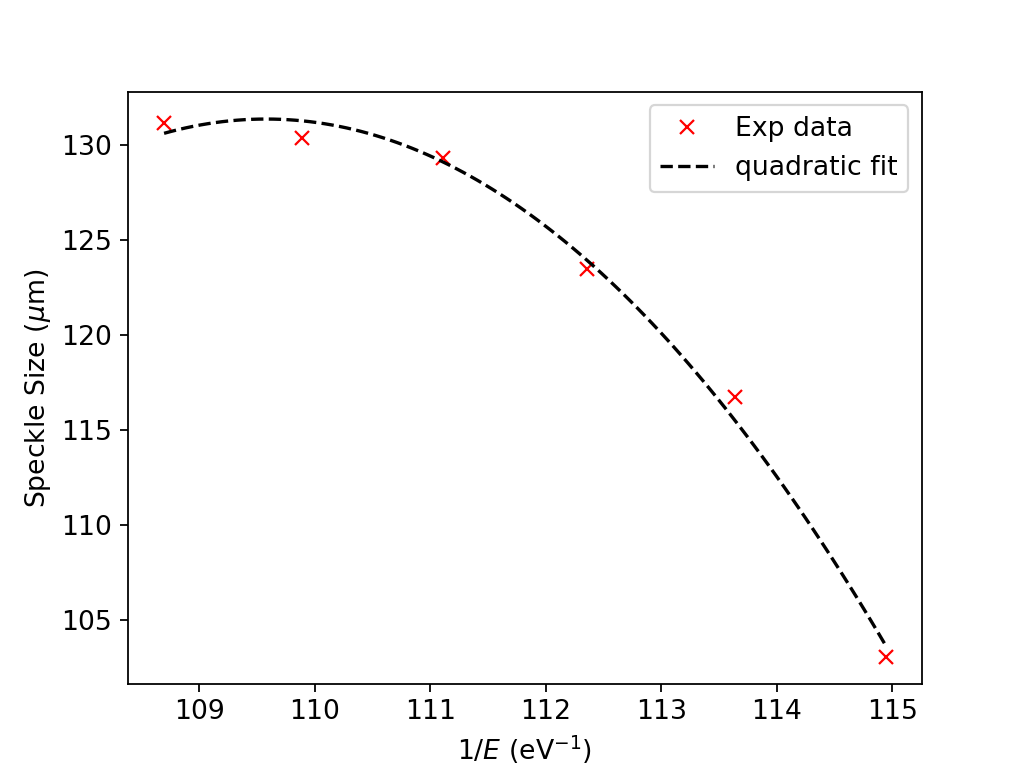

(None,
 array([0.72885493, 0.82539662, 0.87284778, 0.91439744, 0.92147786,
        0.92726503]))

In [248]:
sigma_fit = []
for i in range(len(parameters)):
    sigma_temp = parameters[i][1]
    sigma_fit.append(sigma_temp)
    
fwhm = 2.355*np.array(sigma_fit)
ysize = (fwhm * 200) / np.sqrt(2) #microms

xE = np.array(E_rad/1000)

x = np.linspace(np.min(1/(xE)), np.max(1/(xE)), 100)

def quad(x, a, b, c):
    return a*(x**2) + b*x + c

def func(x, a, b, c):
    return a*x**(2) + b*x + c

p_temp, c_temp = curve_fit(func, 1/(xE), ysize, p0=[-2.358, 517.7, -28230])
p_err = np.sqrt(np.diag(c_temp))

plt.figure()
plt.plot(1/(xE), ysize, 'x', color='red', label = 'Exp data')
plt.plot(x, func(x, p_temp[0], p_temp[1], p_temp[2]), '--',color = 'black', label='quadratic fit')
plt.xlabel(r'$1/E$ (eV$^{-1}$)')
plt.ylabel(r'Speckle Size ($\mu $m)')
plt.legend()

plt.savefig('specklesize-energy.png'), fwhm

<IPython.core.display.Javascript object>


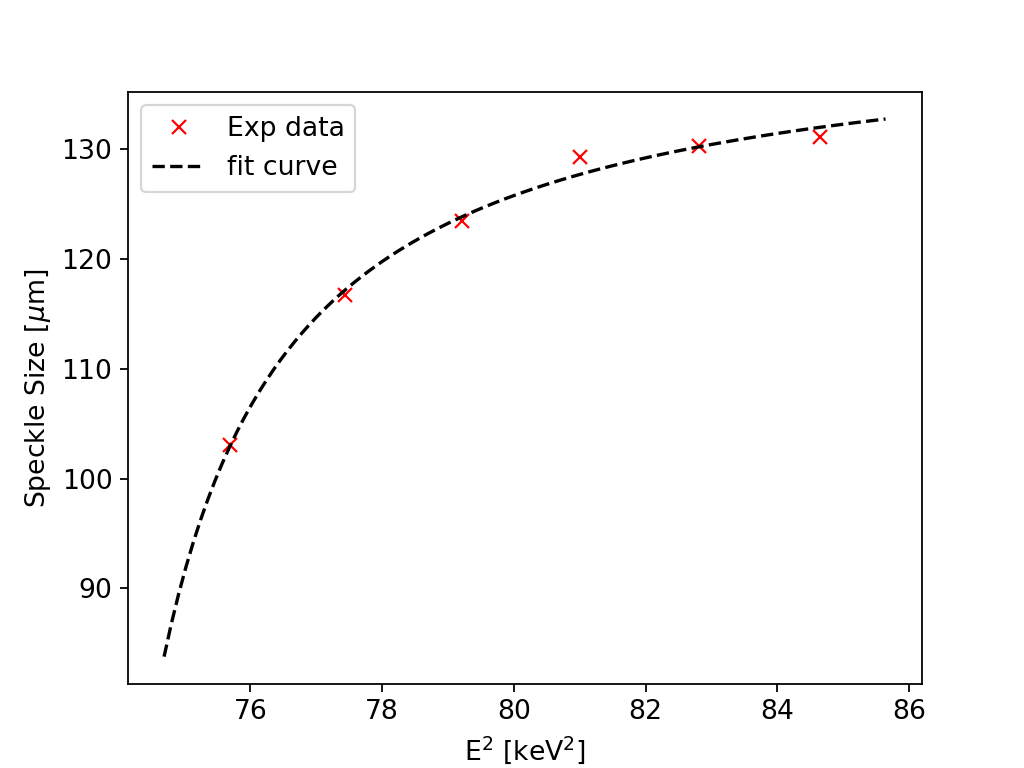

In [263]:
def inverse(x, a , b,  c):
    return a*(1/(x+b)) + c

xE = E_rad

#x = np.linspace(np.min((1/(xE))**2)), np.max((1/(xE))**2))), 100)
p_temp, c_temp = curve_fit(inverse, (xE)**2, ysize, p0=[-148, -71.7, 144])
p_err = np.sqrt(np.diag(c_temp))
x = np.linspace(np.min((xE)**2)-1, np.max((xE)**2)+1, 100)

plt.figure()
plt.plot((xE)**2, ysize, 'x', color='red', label = 'Exp data')
plt.plot(x, inverse(x, p_temp[0], p_temp[1], p_temp[2]), '--', color = 'black', label = 'fit curve')
plt.xlabel(r'E$^{2}$ [keV$^{2}$]')
plt.ylabel(r'Speckle Size [$\mu $m]')
plt.legend()

In [265]:
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit
import sys    
from scipy import stats

sys.path.append('/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 


In [266]:
chi2_object = Chi2Regression(inverse, (xE)**2, ysize)
chi2_object.errordef = 1.0 

Npoints = len(ysize)                       # Set number of data points len(array)
Nvar = 3                         # Set number of varying parameters
Ndof = Npoints - Nvar                # Find degrees of freedom

minuit = Minuit(chi2_object, a = p_temp[0], b = p_temp[1], c = p_temp[2]) 
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.73                       │        Ncalls = 40 (40 total)        │
│ EDM = 1.01e-10 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -118    │    28     │            │            │         │         │       │
│ 1 │ b    │   -72.7   │    0.6    │            │            │         │         │       │
│ 2 │ c    │   141.8   │    2.5    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [304]:
Ndof

3

In [267]:
a_fit, b_fit, c_fit = minuit.values[:]
a_err, b_err, c_err = minuit.errors[:]

<IPython.core.display.Javascript object>


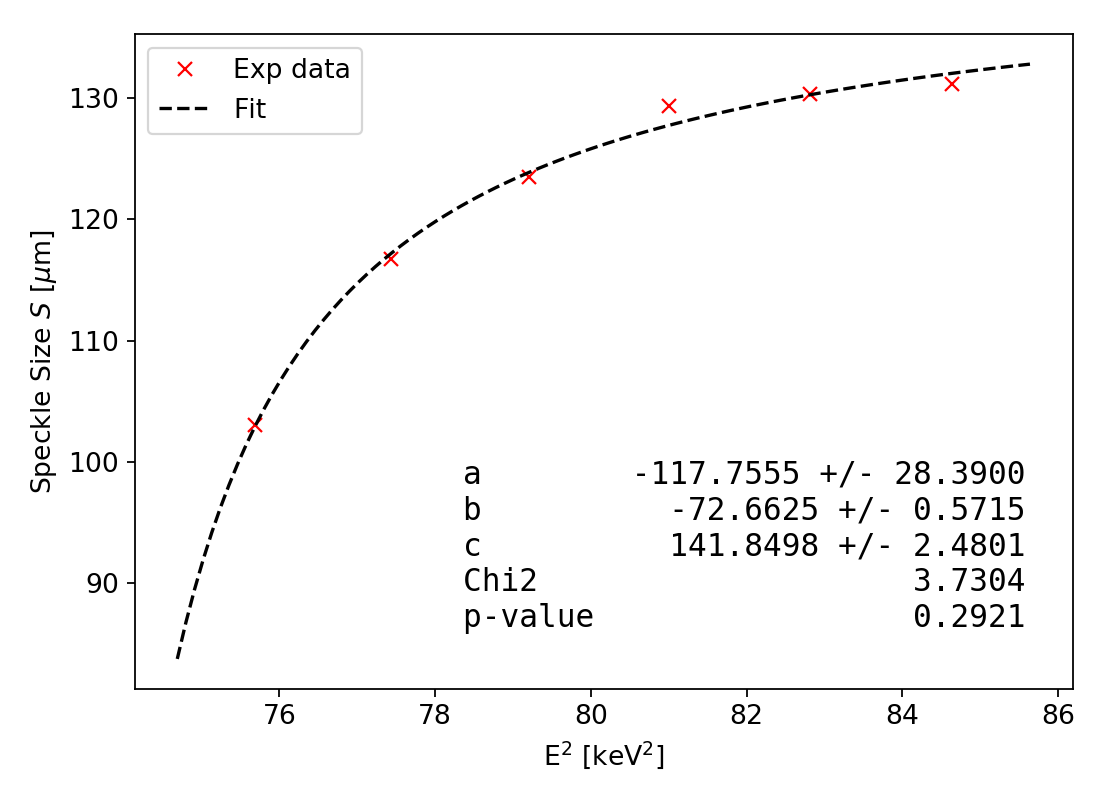

In [303]:
# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots(figsize=(7, 5))  # figsize is in inches

fit = lambda x: inverse(x, a_fit, b_fit, c_fit)
ax.plot((xE)**2, ysize, 'x', color='red', label = 'Exp data')
ax.plot(x, fit(x),  '--',color = 'black',label='Fit')
ax.set_xlabel(r'E$^{2}$ [keV$^{2}$]')
ax.set_ylabel(r'Speckle Size $S$ [$\mu $m]')
ax.legend(loc='upper left')


d = {'a':[a_fit, a_err],
     'b': [b_fit, b_err],
     'c': [c_fit, c_err],
     'Chi2':     Chi2_fit,
     'p-value': Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.35, 0.35, text, ax, fontsize=14)                  #Location of text:  63% Right, 95% Top 
fig.tight_layout()

plt.savefig('speckle_size_beam_exp.png')

In [305]:
xdata = np.array([2.33133106, 2.42526747, 2.51920389, 2.61314031, 2.70707672,
       2.80101314, 2.89494956, 2.98888597, 3.08282239, 3.1767588 ,
       3.27069522, 3.36463164, 3.45856805, 3.55250447, 3.64644088,
       3.7403773 , 3.83431372, 3.92825013, 4.02218655, 4.11612297,
       4.21005938, 4.3039958 , 4.39793221, 4.49186863, 4.58580505,
       4.67974146, 4.77367788, 4.8676143 , 4.96155071, 5.05548713,
       5.14942354, 5.24335996, 5.33729638, 5.43123279, 5.52516921,
       5.61910563, 5.71304204, 5.80697846, 5.90091487, 5.99485129])
ydata = np.array([6.69379563, 6.42755219, 6.18778455, 5.97011689, 5.77049178,
       5.58572589, 5.41351561, 5.25196953, 5.09966772, 4.95556559,
       4.81892489, 4.68885215, 4.56498645, 4.44700749, 4.33458288,
       4.22729118, 4.12495756, 4.02728658, 3.93402466, 3.84492471,
       3.75978982, 3.67824403, 3.60020487, 3.52536114, 3.45356588,
       3.38460348, 3.31835243, 3.25447696, 3.19302673, 3.13379535,
       3.07667521, 3.02164027, 2.9684472 , 2.91721642, 2.86773655,
       2.82001879, 2.77403878, 2.72975194, 2.6871841 , 2.64595888])

In [333]:
def simpinverse(x, a):
    return a*(1/(x))

chi2_object = Chi2Regression(simpinverse, xdata, ydata)
chi2_object.errordef = 1.0 

Npoints = len(ydata)                       # Set number of data points len(array)
Nvar = 1                        # Set number of varying parameters
Ndof = Npoints - Nvar                # Find degrees of freedom

minuit = Minuit(chi2_object, a = 15) 
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.02869                    │        Ncalls = 13 (13 total)        │
│ EDM = 7.1e-19 (Goal: 0.0002)     │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   15.7    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

<IPython.core.display.Javascript object>


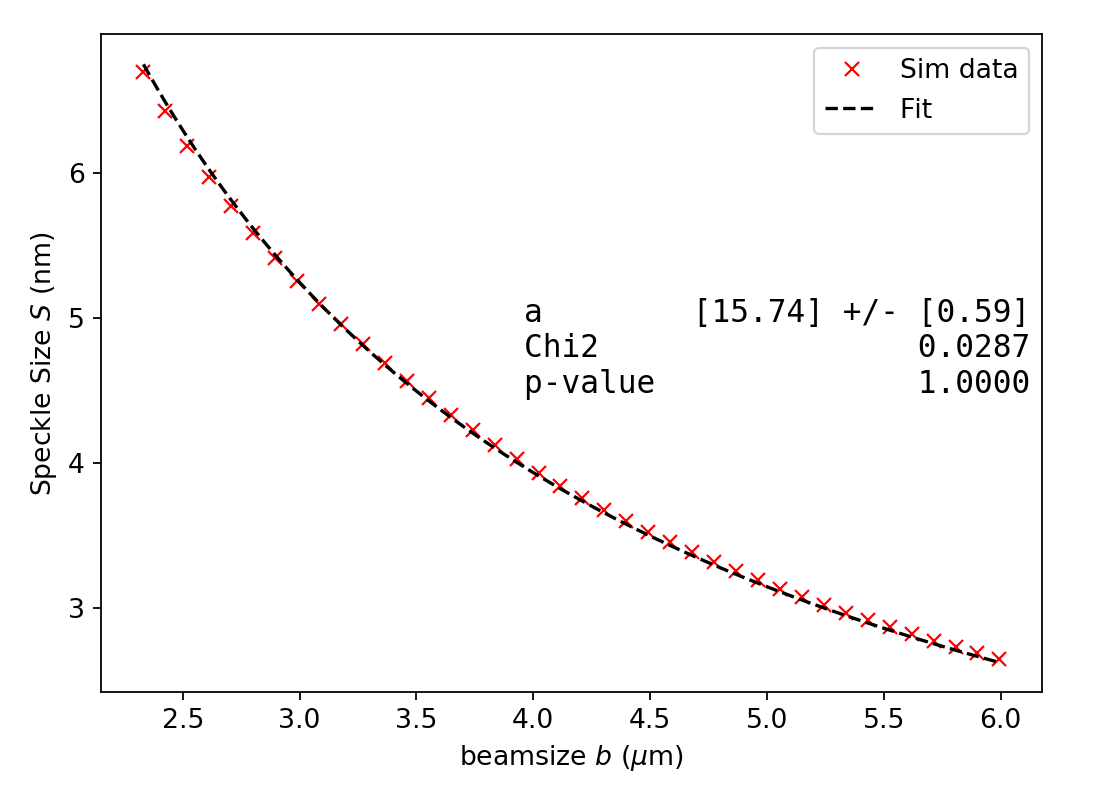

In [334]:
a_fit= minuit.values[:]
a_err= minuit.errors[:]

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots(figsize=(7, 5))  # figsize is in inches

x = np.linspace(np.min(xdata), np.max(xdata), 100)


fit = lambda x: simpinverse(x, a_fit)
ax.plot(xdata, ydata, 'x', color='red', label = 'Sim data')
ax.plot(x, fit(x),  '--',color = 'black',label='Fit')
ax.set_xlabel(r'beamsize $b$ ($\mu$m)')
ax.set_ylabel(r'Speckle Size $S$ (nm)')
ax.legend(loc='upper right')


d = {'a':[np.round(a_fit,2), np.round(a_err,2)],
     'Chi2':     Chi2_fit,
     'p-value': Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.45, 0.60, text, ax, fontsize=14)                  #Location of text:  63% Right, 95% Top 
fig.tight_layout()

plt.savefig('speckle_size_beam_sim.png')

# Average for each run

# Subtracting bkg

In [335]:
Ndof

39